## Advanced Seminar for Recognition System
##### Masashi Nakayama - Fall Semester 2025/26
### Jan Niklas Kappey (ID: 2568017)


**Create a linearly indistinguishable multi-class classification
system using a multi-layer perceptron. Please present your
findings, including any ingenuity you have used.**

In [1]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

print("Path to dataset files:", path)
print(os.listdir(path))

2026-01-21 13:31:58.550265: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-21 13:31:58.870263: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-21 13:31:59.218072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768969919.428311    2426 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768969919.510033    2426 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768969920.076606    2426 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Path to dataset files: /home/nikla/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2
['rps-cv-images', 'scissors', 'rock', 'README_rpc-cv-images.txt', 'paper']


In [2]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices("GPU"))

GPUs: []


2026-01-21 13:32:10.539458: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
labels = ['paper','scissors','rock']

In [4]:
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [5]:
from keras.saving import register_keras_serializable

@register_keras_serializable()
class CNN(Model):
    def __init__(self, hidden_dim=512, output_dim=3):
        super().__init__()
        self.l1 = Conv2D(32, (3, 3), activation='relu')
        self.l2 = MaxPooling2D((2, 2))
        self.l3 = Conv2D(32, (3, 3), activation='relu')
        self.l4 = MaxPooling2D((2, 2))
        self.l5 = Flatten()
        self.l6 = Dense(hidden_dim, activation='relu')
        self.l7 = Dense(output_dim, activation='softmax')

        # Define the layer sequence you intended to iterate through
        self.ls = [self.l1, self.l2, self.l3, self.l4, self.l5, self.l6, self.l7]

    def call(self, x, training=False):
        if training:
            x = data_augment(x)
        for layer in self.ls:
            x = layer(x)
        return x


In [6]:
def input_target_split(root_dir, labels, image_size=(150, 150)):
    dataset = []
    for class_id, label in enumerate(labels):
        folder = os.path.join(root_dir, label)
        if not os.path.isdir(folder):
            raise FileNotFoundError(
                f"Couldn't find folder: {folder}\n"
                f"Check your dataset path. Top-level contents: {os.listdir(root_dir)}"
            )

        for fname in os.listdir(folder):
            fpath = os.path.join(folder, fname)
            img = load_img(fpath, target_size=image_size)
            img = img_to_array(img).astype("float32") / 255.0
            dataset.append((img, class_id))

    X, y = zip(*dataset)
    return np.array(X, dtype="float32"), np.array(y, dtype="int32")

In [7]:
X, y = input_target_split(path,labels)

In [8]:
# train / val / test split
x_train, x_tmp, t_train, t_tmp = train_test_split(
    X, y, test_size=0.3, random_state=1234, stratify=y)

x_val, x_test, t_val, t_test = train_test_split(
    x_tmp, t_tmp, test_size=0.67, random_state=1234, stratify=t_tmp)


In [9]:
n = len(labels)
model = CNN(hidden_dim=12, output_dim=n)

# IMPORTANT: use sparse loss/acc since labels are integers
criterion = losses.SparseCategoricalCrossentropy()
optimizer = optimizers.SGD(learning_rate=0.01)

train_loss = metrics.Mean(name="train_loss")
train_acc = metrics.SparseCategoricalAccuracy(name="train_acc")
val_acc = metrics.SparseCategoricalAccuracy(name="val_acc")

In [10]:
def compute_loss(t, y):
    return criterion(t, y)

@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        preds = model(x, training=True)
        loss = criterion(t, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss.update_state(loss)
    train_acc.update_state(t, preds)
    return loss

@tf.function
def test_step(x, t):
    preds = model(x, training=False)
    loss = criterion(t, preds)
    test_loss.update_state(loss)
    test_acc.update_state(t, preds)
    return loss
    
@tf.function
def val_step(x, t):
    preds = model(x, training=False)
    val_acc.update_state(t, preds)

In [11]:
epochs = 6
batch_size = 20
n_batches = x_train.shape[0] // batch_size

loss_history = []
acc_history = []

for epoch in range(epochs):
    # reset metrics EACH epoch (otherwise they accumulate across epochs)
    train_loss.reset_state()
    train_acc.reset_state()

    x_, t_ = shuffle(x_train, t_train, random_state=epoch)

    for batch in range(n_batches):
        start = batch * batch_size
        end = start + batch_size
        train_step(x_[start:end], t_[start:end])
        
    loss_history.append(train_loss.result().numpy())
    acc_history.append(train_acc.result().numpy())

    val_acc.reset_state()
    val_step(x_val, t_val)

    print(
    f"epoch: {epoch+1}, "
    f"loss: {train_loss.result():.3f}, "
    f"train_acc: {train_acc.result():.3f}, "
    f"val_acc: {val_acc.result():.3f}"
)

2026-01-21 13:32:35.019325: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 605601792 exceeds 10% of free system memory.


epoch: 1, loss: 1.103, train_acc: 0.322, val_acc: 0.338


2026-01-21 13:32:54.824097: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 605601792 exceeds 10% of free system memory.


epoch: 2, loss: 1.097, train_acc: 0.355, val_acc: 0.343


2026-01-21 13:33:14.855762: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 605601792 exceeds 10% of free system memory.


epoch: 3, loss: 1.096, train_acc: 0.345, val_acc: 0.343


2026-01-21 13:33:36.207697: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 605601792 exceeds 10% of free system memory.


epoch: 4, loss: 1.093, train_acc: 0.373, val_acc: 0.421


2026-01-21 13:33:51.730712: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 605601792 exceeds 10% of free system memory.


epoch: 5, loss: 1.089, train_acc: 0.398, val_acc: 0.444
epoch: 6, loss: 1.082, train_acc: 0.420, val_acc: 0.486


In [12]:
test_loss = metrics.Mean(name="test_loss")
test_acc = metrics.SparseCategoricalAccuracy(name="test_acc")

test_loss.reset_state()
test_acc.reset_state()
val_step(x_test, t_test)

print(f"test_loss: {test_loss.result():.3f}, test_acc: {test_acc.result():.3f}")

test_loss: 0.000, test_acc: 0.000


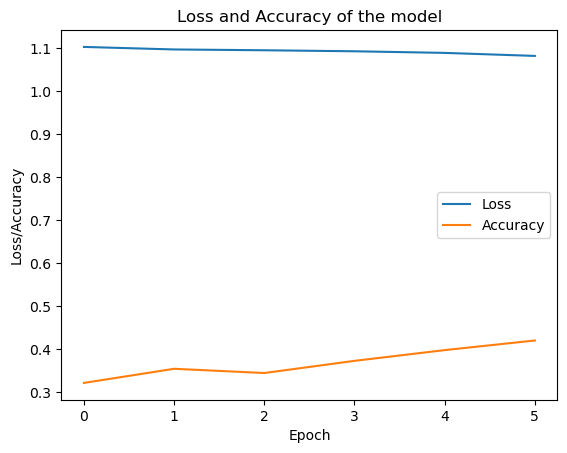

In [13]:
plt.figure()  
plt.plot(loss_history)
plt.plot(acc_history)
plt.title('Loss and Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend(['Loss', 'Accuracy'])
plt.show()


In [14]:
from sklearn.metrics import confusion_matrix, classification_report

preds = model(x_test, training=False).numpy().argmax(axis=1)

print("Confusion Matrix:")
print(confusion_matrix(t_test, preds))

print("\nClassification Report:")
print(classification_report(t_test, preds, target_names=labels))

Confusion Matrix:
[[111  33   0]
 [ 45 106   0]
 [ 81  65   0]]

Classification Report:
              precision    recall  f1-score   support

       paper       0.47      0.77      0.58       144
    scissors       0.52      0.70      0.60       151
        rock       0.00      0.00      0.00       146

    accuracy                           0.49       441
   macro avg       0.33      0.49      0.39       441
weighted avg       0.33      0.49      0.39       441



/home/nikla/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nikla/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nikla/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


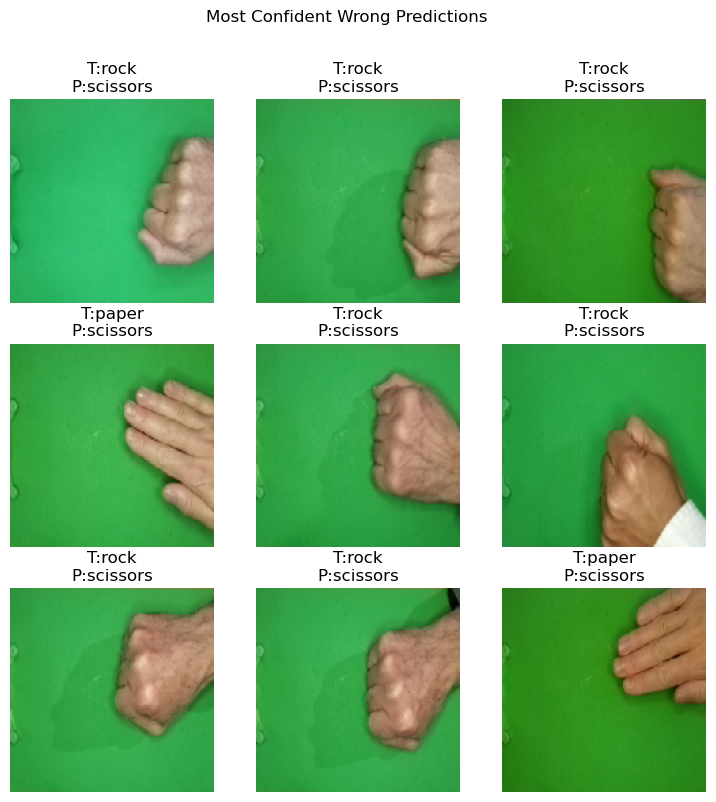

In [15]:
probs = model(x_test, training=False).numpy()
conf = probs[np.arange(len(probs)), preds]
wrong = np.where(preds != t_test)[0]

top_wrong = wrong[np.argsort(-conf[wrong])[:9]]

plt.figure(figsize=(9,9))
for i, idx in enumerate(top_wrong):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[idx])
    plt.title(f"T:{labels[t_test[idx]]}\nP:{labels[preds[idx]]}")
    plt.axis("off")
plt.suptitle("Most Confident Wrong Predictions")
plt.show()

In [17]:
# Download latest version
path2 = kagglehub.dataset_download("glushko/rock-paper-scissors-dataset")


# Simple approach: ignore boxes, just resize whole images
X2, y2 = input_target_split(path2 + "/test", labels)

# small subset to keep it fair
X2, y2 = X2[:300], y2[:300]

preds2 = model(X2, training=False).numpy().argmax(axis=1)

print("Cross-dataset accuracy:",
      np.mean(preds2 == y2))

Cross-dataset accuracy: 0.55
